This is an enormous notebook used to generate plots for the CX paper, but also to try explain a little how it works

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy as np
import scipy as sp
from scipy.signal import lfilter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as patches

import central_complex as cx

In [6]:
mpl.rc('font', family='Arial', size=14)

In [30]:
nature_single = 89.0 / 25.4
nature_double = 183.0 / 25.4
nature_full = 247.0 / 25.4

outbound_color = 'purple'

label_font_size = 11
unit_font_size = 10

T_inbound = T_outbound = 1000
average_speed = 0.55  # Not exactly but its midpoint between 0.1 and 1.0

## Generating routes

In [49]:
def gen_route(T_outbound=1500, T_inbound=1500, sigma=0.15, min_speed=0.1):
    """Generates a new outbound route"""

    T = T_outbound + T_inbound

    # Create a random change in derivative of the heading function
    # This should make curves smoother as derivative of turns will stay smooth-ish
    heading_delta_delta = np.random.normal(loc=0, scale=sigma, size=T_outbound)
    
    # Decay this derivative towards zero, to avoid too much loopiness
    heading_delta = lfilter([1.0], [1, -0.4], heading_delta_delta)

    # Update heading based on the delta
    heading_outbound = np.cumsum(heading_delta)
    heading_inbound = np.empty(T_inbound) 
    heading_inbound[:] = np.NAN
    heading = np.hstack([heading_outbound, heading_inbound])
    
    speed_outbound = np.max(np.abs(heading_delta)) - np.abs(heading_delta)

    # Run a wide Gaussian filter to simulate speeding up and slowing down for corners
    speed_smoothed = sp.ndimage.filters.gaussian_filter1d(speed_outbound, 20.)
    speed_scaled = min_speed + ((1-min_speed) * (speed_smoothed - np.nanmin(speed_smoothed)) / 
                   (np.nanmax(speed_smoothed) - np.nanmin(speed_smoothed)))
    speed_scaled = np.clip(speed_scaled, 0, 1)

    speed_inbound = np.ones(T_inbound) * (min_speed + 1.0) / 2
    speed = np.hstack([speed_scaled, speed_inbound])
    
    # testing what happens when the speed input is not exact
    noduli_speed = np.clip(speed,0.8,0.9)

    x = np.hstack([0, np.cumsum(speed * np.cos(heading))])
    y = np.hstack([0, np.cumsum(speed * np.sin(heading))])
    
    return x, y, heading, speed, noduli_speed

In [16]:
def run_trial(T_outbound, T_inbound, x, y, heading, speed, noise=0.1, motor_change=0.5):
    """Follows route and then attempts to go home"""
    
    c = cx.CX(noise=noise)
    T = T_outbound + T_inbound
    
    # Some logs for each cell type
    tl2 = np.zeros([cx.n_tl2, T])
    cl1 = np.zeros([cx.n_cl1, T])
    tb1 = np.zeros([cx.n_tb1, T])
    memory = np.zeros([cx.n_cpu4, T])
    memory[:,0] = 0.5 * np.ones(cx.n_cpu4)
    cpu4 = np.zeros([cx.n_cpu4, T])
    cpu1 = np.zeros([cx.n_cpu1, T])
    motor = np.zeros(T)

    # Loop through each time step
    for t in range(1, T):
        # Compass info (current heading as arrived at new location)
        tl2[:,t] = c.tl2_output(heading[t-1])
        cl1[:,t] = c.cl1_output(tl2[:,t])
        tb1[:,t] = c.tb1_output(cl1[:,t], tb1[:,t-1])

        # Update memory for distance just travelled
        memory[:,t] = c.cpu4_update(memory[:,t-1], tb1[:,t], speed[t-1])
        cpu4[:,t] = c.cpu4_output(memory[:,t])

        # Generate turn
        cpu1[:,t] = c.cpu1_output(tb1[:,t], cpu4[:,t])
        motor[t] = np.sum(c.motor_output(cpu1[:,t]))

        # After the final outbound step start updating the heading and checking if home
        if t >= T_outbound and t < T:
            heading[t] = heading[t-1] - motor_change * motor[t] 

            x[t+1] = x[t] + np.cos(heading[t]) * speed[t]
            y[t+1] = y[t] + np.sin(heading[t]) * speed[t]
            
    return tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y

In [10]:
def plot_route(x, y, T_outbound, T_inbound, plot_speed=False, ax=None, x_lim=None, y_lim=None, legend=True):
    """Plots a route"""
    
    lw =0.5
    T = T_outbound + T_inbound
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,12))
    else:
        fig = None
        
    if plot_speed:
        speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]), axis=0), 0, 1)
        
        n_min = np.argmin(speed[:T_outbound])
        n_max = np.argmax(speed[:T_outbound])
            
        for i in range(T_outbound-1):
            ax.plot(x[i:i+2], y[i:i+2], color=(speed[i],0.2,1-speed[i]), lw=lw)
            
        blue_line = mlines.Line2D([], [], color='blue', label='Outbound (slow)')
        red_line = mlines.Line2D([], [], color='red', label='Outbound (fast)')
        handles = [blue_line, red_line]
    else:
        line_out, = ax.plot(x[0:T_outbound+1], y[0:T_outbound+1], lw=lw, color=outbound_color, label='Outbound')
        handles = [line_out]
    
    line_in, = ax.plot(x[T_outbound:T], y[T_outbound:T], 'g', lw=lw, label='Return')
    
    handles.append(line_in)
    ax.set_xlabel('Distance (steps)')
    ax.set_ylabel('Distance (steps)')
    ax.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
    ax.set_aspect('equal')
    ax.tick_params(labelsize=unit_font_size)
    
    # Legend
    if legend:
        l = ax.legend(handles=handles,
                      loc='best',
                      fontsize=unit_font_size,
                      handlelength=0,
                      handletextpad=0)
        if plot_speed:
            colors = ['blue', 'red', 'green']
        else:
            colors = ['purple', 'green']
        for i, text in enumerate(l.get_texts()):
            text.set_color(colors[i])
        for handle in l.legendHandles:
            handle.set_visible(False)
        l.draw_frame(False)
        
    return ax, fig

Generate a new random outbound route

In [50]:
x, y, heading, speed, noduli_speed = gen_route(T_outbound, T_inbound)


Plot the speed and noduli_speed

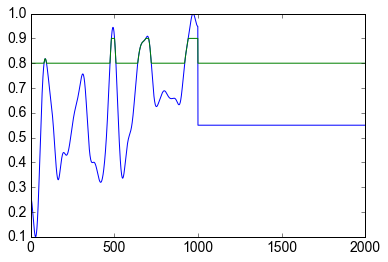

In [51]:
plt.plot(speed)
plt.plot(noduli_speed)
plt.show()

Run trial using actual speed input

In [56]:
tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound, T_inbound, x, y, heading, speed)

Run trial using modified noduli_speed input

In [54]:
tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound, T_inbound, x, y, heading, noduli_speed)

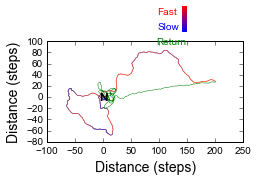

In [57]:
fig, ax = plt.subplots(figsize=(nature_single, nature_single))
plot_route(x, y, T_outbound, T_inbound, ax=ax, plot_speed=True, legend=False)

cdict = {'red':[(0,0,0), (0.5,0.5,0.5), (1,1,1)],
         'green':[(0,0,0), (0.5,0,0), (1,0,0)],
         'blue':[(0,1,1), (0.5,0.5,0.5), (1,0,0)]}
red_blue = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 256)
    
cax = fig.add_axes([0.66, 0.75, 0.02, 0.1])
m = cm.ScalarMappable(cmap=red_blue)
m.set_array(np.linspace(0, 1, 100))
cb = fig.colorbar(m, cax, ticks=[0, 0.2, 0.4, 0.8, 1])
cb.ax.set_yticklabels(['','Slow','','Fast',''])
cb.outline.set_visible(False)
cb.ax.yaxis.set_ticks_position('left')
cax.tick_params(axis='y', which='major', pad=25)
plt.setp(plt.getp(cax, 'yticklabels')[1], color='b', fontsize=unit_font_size, ha='left')
plt.setp(plt.getp(cax, 'yticklabels')[3], color='r', fontsize=unit_font_size, ha='left')
for tic in cb.ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
cax.text(-2.1, -0.4, 'Return', fontsize=unit_font_size, color='g', ha='center', va='center')

Need to set up to visualise what is actual effect of speed on memory input, how the home vector in memory differs from the correct position estimate during a trial, and to run multiple trials with a simple homing accuracy measure

In [16]:
def plot_traces(tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y,
                T_outbound, T_inbound, colormap='viridis', title_x=-0.15):
    """Generate big plot with all traces of model. Warning: takes long time to save!!"""
    T = T_outbound + T_inbound
    alpha = 0.2
    titles = ['TL2', 'CL1', 'TB1 (Compass)', 'CPU4 (Memory)', 'CPU1 (Steering)', 'motor']
    data = [tl2, cl1, tb1, cpu4, cpu1, motor]
    dashes = [1, 2, 1, 2]

    fig, ax = plt.subplots(6,1, figsize=(nature_single, nature_single))
    
    for i in range(len(titles)):
        ax[i].set_title(titles[i],
                        x=title_x,
                        y=0.3,
                        va='center',
                        ha='right',
                        fontsize=label_font_size,
                        fontweight='heavy')
        if i == 2:
            ax[i].set_ylabel('Cell indices', fontsize=label_font_size)
        if i < 5:
            p = ax[i].pcolormesh(data[i], vmin=0, vmax=1, cmap=colormap, rasterized=True)
            ax[i].set_xticklabels([])
            ax[i].get_xaxis().set_tick_params(direction='out')

            if i == 2:
                ax[i].set_yticks([1,7])
                ax[i].set_yticklabels([1,8], fontsize=unit_font_size)
            else:
                ax[i].set_yticks([1,14])
                ax[i].set_yticklabels([1,16], fontsize=unit_font_size)
                
            if i == 4:
                fig.savefig('dummy.jpg') # This is needed to force draw the plot
                p.get_facecolors().reshape(16,-1, 4)[:,:T_outbound,3] = 0.1
                p.set_edgecolor('none')
            else:
                p.set_edgecolor('face')
        else:
            ax[i].plot(np.arange(T_outbound),
                       motor[:T_outbound],
                       color=outbound_color,
                       lw=0.5,
                       label='Outbound',
                       alpha=alpha)
            ax[i].plot(np.arange(T_outbound, T),
                       motor[T_outbound:],
                       color='g',
                       lw=0.5,
                       label='Return')
            ax[i].set_xlabel('Time (steps)', fontsize=label_font_size)
            ax[i].set_ylabel('$\Sigma$ activity',
                             labelpad=-1,
                             fontsize=label_font_size)
            ax[i].tick_params(labelsize=unit_font_size)
            ax[i].set_yticks([-2.5, 0, 2.1])
            ax[i].set_yticklabels([-3, 0, 3],
                                  fontsize=unit_font_size)
            ax[i].get_xaxis().set_major_formatter(
                    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            
            dummy_ax = ax[i].twinx()
            dummy_ax.set_ylim([-3, 3])
            dummy_ax.set_yticks([-2.5, 2.1])
            dummy_ax.set_yticklabels(['L','R'],
                                     position=(1.02,0),
                                     fontsize=unit_font_size,
                                     va='center',
                                     ha='center')
            
    # Colorbar
    ax_cb = fig.add_axes([0.92, 0.257, 0.02, 0.643])
    m = cm.ScalarMappable(cmap=colormap)
    m.set_array(np.linspace(0, 1, 100))
    ax_cb.tick_params(labelsize=unit_font_size)
    cb = fig.colorbar(m, ax_cb)
    cb.set_label('Firing rate', size=label_font_size)
    
    # Top spacer
    ax_space = fig.add_axes([0, 0.92, 1, 0.01])
    ax_space.axis('off')
    
    # Dotted bars
    v_indices = np.array([0, 1000, 1300, 2000])
    transFigure = fig.transFigure.inverted()
    for i, v_idx in enumerate(v_indices):
        coord1 = transFigure.transform(ax[0].transData.transform([v_idx,15]))
        coord2 = transFigure.transform(ax[5].transData.transform([v_idx,-3]))
        if i == 0 or i == 3:
            lw=1
            zorder=0
        else:
            lw=1
            zorder=1
        line = mlines.Line2D((coord1[0],coord2[0]),(coord1[1]+0.06,coord2[1]),
                             transform=fig.transFigure, lw=lw, zorder=zorder, c='w', linestyle='dashed')
        line.set_dashes(dashes)
        fig.lines.append(line)
        line = ax[5].axvline(x=v_idx, lw=lw, c='#333333', linestyle='dashed')
        line.set_dashes(dashes)

    # Labels between bars
    label_indices = (v_indices[:3] + v_indices[1:])/2
    labels = ['Outbound', 'Return', 'Search']
    for i, label_idx in enumerate(label_indices):
        ax[0].text(label_idx, 20, labels[i], fontsize=label_font_size, va='center', ha='center')

    return fig, ax

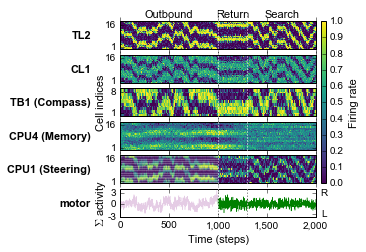

In [17]:
fig, ax = plot_traces(tl2=tl2,
                      cl1=cl1,
                      tb1=tb1,
                      memory=memory,
                      cpu4=cpu4,
                      cpu1=cpu1,
                      motor=motor,
                      x=x,
                      y=y,
                      T_outbound=T_outbound,
                      T_inbound=T_inbound)
plt.show()